In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, BatchNormalization, LeakyReLU, Dropout, Reshape,UpSampling2D,Input
from tensorflow.keras.models import Sequential,Model
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import datetime
from tensorflow.keras import callbacks,layers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Rescale pixel values and set the target size for resizing
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

batch_size = 32
base_path = "/content/drive/MyDrive/Cancer_Dataset/lung_colon_image_set"

target_size = (256, 256)  # Assuming you want to resize to this size

# Train generator
lung_colon_train_generator = datagen.flow_from_directory(
    base_path,
    target_size=target_size,
    batch_size=batch_size,
    classes=["colon_aca", "colon_n", "lung_aca", "lung_n", "lung_scc"],
    shuffle=True,
    subset="training"
)

# Test/Validation generator
lung_colon_test_generator = datagen.flow_from_directory(
    base_path,
    target_size=target_size,
    batch_size=batch_size,
    classes=["colon_aca", "colon_n", "lung_aca", "lung_n", "lung_scc"],
    shuffle=True,
    subset="validation"
)


Found 17899 images belonging to 5 classes.
Found 4474 images belonging to 5 classes.


In [ ]:
def build_encoder(img_shape,latent_dim):
        init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(layers.Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same', kernel_initializer=init))
        model.add(layers.LeakyReLU(0.2))
        model.add(layers.BatchNormalization(momentum=0.8))

        for filters in [64, 128]:
            model.add(layers.Conv2D(filters, kernel_size=3, strides=2, padding='same', kernel_initializer=init))
            model.add(layers.LeakyReLU(0.2))
            model.add(layers.BatchNormalization(momentum=0.8))

        model.add(layers.Flatten())
        model.add(layers.Dense(latent_dim, activation='tanh'))
        return model

In [ ]:
encoder=build_encoder(img_shape=(256,256,3),latent_dim=100)
encoder.load_weights('/content/drive/MyDrive/Cancer_Dataset/encoder_weights_epoch_9.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
# Extract features
train_features = encoder.predict(lung_colon_train_generator)

560/560 [==============================] - 4943s 9s/step


In [ ]:
y_train = []

# Loop over each batch from the generator
for i in range(len(lung_colon_train_generator)):
    _, batch_labels = lung_colon_train_generator[i]
    y_train.extend(batch_labels)

# Convert the list of arrays to a single numpy array
y_train = np.vstack(y_train)

print(y_train.shape)  # This will give you a sense of the size and structure of y_train


(17899, 5)


In [ ]:
y_train_categorical = np.argmax(y_train, axis=1)

In [ ]:
NUM_CLASSES=5
# Define the classifier
classifier = Sequential([
    layers.Input(shape=(train_features.shape[1:])),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')  # NUM_CLASSES
])

# Compile the model
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = classifier.fit(train_features, y_train, batch_size=32, epochs=100)

Epoch 1/100
560/560 [==============================] - 2s 3ms/step - loss: 1.5779 - accuracy: 0.2241
Epoch 2/100
560/560 [==============================] - 2s 3ms/step - loss: 1.5779 - accuracy: 0.2284
Epoch 3/100
560/560 [==============================] - 2s 3ms/step - loss: 1.5779 - accuracy: 0.2290
Epoch 4/100
560/560 [==============================] - 2s 3ms/step - loss: 1.5777 - accuracy: 0.2258
Epoch 5/100
560/560 [==============================] - 2s 3ms/step - loss: 1.5774 - accuracy: 0.2258
Epoch 6/100
560/560 [==============================] - 2s 4ms/step - loss: 1.5774 - accuracy: 0.2292
Epoch 7/100
560/560 [==============================] - 2s 4ms/step - loss: 1.5770 - accuracy: 0.2282
Epoch 8/100
560/560 [==============================] - 2s 3ms/step - loss: 1.5771 - accuracy: 0.2300
Epoch 9/100
560/560 [==============================] - 2s 3ms/step - loss: 1.5768 - accuracy: 0.2283
Epoch 10/100
560/560 [==============================] - 2s 3ms/step - loss: 1.5766 - accura

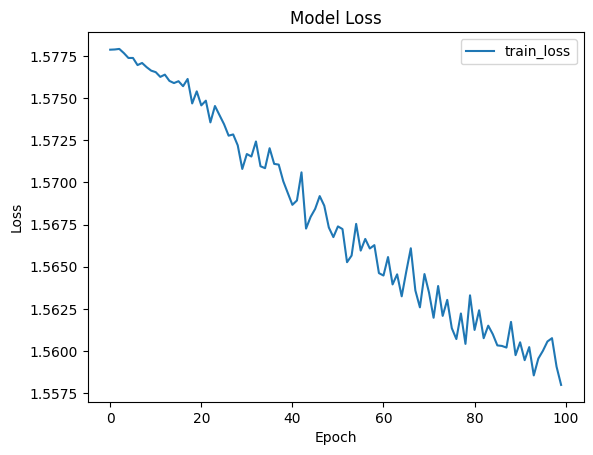

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history['loss'], label='train_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()
